## Show avg prediction and variance for synthetic data

In [27]:
import numpy as np
import pandas as pd

from sklearn.linear_model import LinearRegression, Ridge, Lasso, LogisticRegression
from sklearn.ensemble import RandomForestClassifier, RandomForestRegressor
from sklearn.datasets import load_boston, load_iris, load_wine, load_digits, \
                             load_breast_cancer, load_diabetes
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, precision_score, recall_score

from sklearn.tree import DecisionTreeClassifier, DecisionTreeRegressor
from sklearn.metrics import mean_absolute_error

import matplotlib.pyplot as plt
%config InlineBackend.figure_format = 'retina'

from rfpimp import *

from sklearn import tree
from dtreeviz.trees import *

def jeremy_trick_RF_sample_size(n):
    # Jeremy's trick
    from sklearn.ensemble import _forest as forest
    forest._generate_sample_indices = \
        (lambda rs, n_samples: forest.check_random_state(rs).randint(0, n_samples,n))

In [28]:
def rent():
    # can't use too many records as model.score() will be average of many values
    # which reduces variance; we're trying to highlight not hide that variance
    df_rent = pd.read_csv("data/rent-ideal.csv")
    X = df_rent[['bedrooms','bathrooms','latitude','longitude']].values
    y = df_rent['price'].values

    # shuffle
    idx = np.random.permutation(len(X))
    X = X[idx]
    y = y[idx]
    return X, y

def testobs(X, y, nchunks = 200, ntests=5):
    n = len(X)
    chunk_size = n // nchunks

    # grab say just 5 records; too many and average r2 over test set shows too little variance
    if chunk_size<ntests:
        raise "Oops"
    X_test, y_test = X[0:ntests], y[0:ntests]
    return X_test, y_test, chunk_size

In [29]:
def showme(tree_sizes,all_test_errors,all_test_scores,max_features,min_samples_leaf=1,
          std_range=(0,.13),
          y_range=(0,0.3)):
    test_means = np.mean(all_test_errors, axis=0)
    test_stds = np.std(all_test_errors, axis=0)
    test_variances = np.var(all_test_errors, axis=0)
    test_r2_means = np.mean(all_test_scores, axis=0)
    test_r2_stds = np.std(all_test_scores, axis=0)
    test_r2_variances = np.var(all_test_scores, axis=0)

    fig, ax = plt.subplots(1, 1, figsize=(4,2.8))
    a = ax.plot(tree_sizes, test_r2_means, lw=.75, marker='.', label="test $R^2$")

    plt.fill_between(tree_sizes, 
                     test_r2_means - test_r2_stds,
                     test_r2_means + test_r2_stds,
                     color='gray', alpha=0.2, label="test $R^2$ $\sigma$")

    ax2 = ax.twinx()
    b = ax2.plot(tree_sizes, test_r2_stds, lw=1, label="test set stdev", c='orange')
    ax2.yaxis.label.set_color('orange')
    ax2.tick_params(axis='y', colors='orange')
    ax2.set_ylim(*std_range)

    ax.legend(loc='lower right')
    ax.set_xlabel("Num trees in forest")
    ax.set_ylabel("Test set $R^2$")
    ax.set_ylim(*y_range)
    
    if max_features==1.0:
        ax.set_title(f"BAGGING test error vs num trees, {min_samples_leaf} samples/leaf", fontsize=10)
    else:
        ax.set_title(f"RF rest error vs num trees, {min_samples_leaf} samples/leaf", fontsize=10) 

In [30]:
def sim_ntrees(X_train, X_test, y_train, y_test,
                max_features = 'auto',
                min_samples_leaf=1,      # lowest bias but increases variance
                ntrials = 5,
              tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50]):

    all_test_scores = np.zeros(shape=(ntrials,len(tree_sizes)))
    for i in range(ntrials):
        print(f" {i}", end='')
        test_scores = []
        for j,n_estimators in enumerate(tree_sizes):
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=True,
                                      n_jobs=-1)
            rf.fit(X_train, y_train)
            s = mean_absolute_error(y_test, rf.predict(X_test))
    #         s = rf.score(X_test, y_test)
            test_scores.append(s)

        all_test_scores[i] = test_scores
        avg = np.mean(test_scores)
        
    return all_test_scores, tree_sizes

## bulldozer data

In [31]:
def bulldozer(basefeatures = ['SalesID',
                    'MachineID', 'ModelID',
                    'datasource', 'YearMade',
                    # some missing values but use anyway:
                    'auctioneerID', 'MachineHoursCurrentMeter']):
    df_bull = pd.read_feather("data/bulldozer-train.feather") # these are sorted by date

    df_bull = df_bull.fillna(0) # flip missing numeric values to zeros

    ntest = 15_000
    df_bull_test = df_bull.iloc[-ntest:] # take only last 100,000 records
    df_bull_train = df_bull.iloc[-(100_000+ntest):-ntest] # train only last 100,000 records

    X_train, y_train = df_bull_train[basefeatures], df_bull_train['SalePrice']
    X_test, y_test = df_bull_test[basefeatures], df_bull_test['SalePrice']

    return X_train, X_test, y_train, y_test

#### Overfitting

Can try playing with min_samples_leaf, but better to remove features that cause overfitting. SalesID is unique record ID never to be seen again.  Remove that and accuracy on validation set goes higher. Lesson: it's about the features not the model so much.

In [ ]:
features=[
    'MachineID', 'ModelID',
    'datasource', 'YearMade',
    'auctioneerID', 'MachineHoursCurrentMeter']

X_train, X_test, y_train, y_test = bulldozer(basefeatures=features)

#max_features = len(X_train.columns)
max_features = len(X_train.columns)
min_samples_leaf = 1
ntrials = 5

all_test_scores, tree_sizes = sim_ntrees(X_train, X_test, y_train, y_test, ntrials=ntrials,
                                         max_features=max_features,
                                         min_samples_leaf=min_samples_leaf,
                                         tree_sizes=[1,2,3,4,5,6,10,15,20,30,40,50,100])
test_means = np.mean(all_test_scores, axis=0)
test_variances = np.std(all_test_scores, axis=0)
test_variances

 0 1

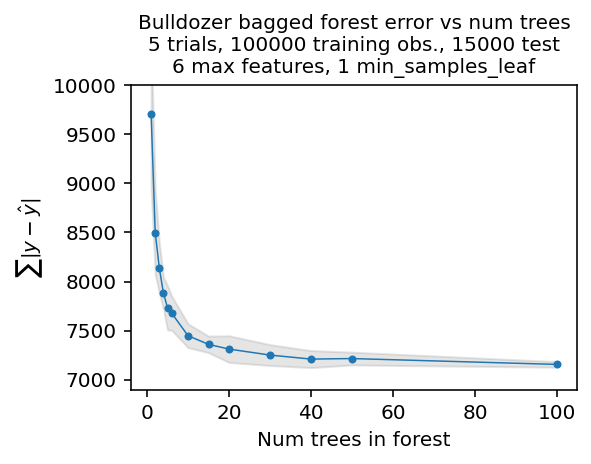

In [7]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, test_means, lw=.75, marker='.', label="test set $\sum |y - \hat{y}|$")

plt.fill_between(tree_sizes, 
                 test_means - test_variances*3,
                 test_means + test_variances*3,
                 color='gray', alpha=0.2)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("$\sum |y - \hat{y}|$")
ax.set_ylim(6900,10_000)

if max_features==len(X_train.columns):
    ax.set_title(f"Bulldozer bagged forest error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)
else:
    ax.set_title(f"Bulldozer RF error vs num trees\n{ntrials} trials, {len(X_train)} training obs., {len(X_test)} test\n{max_features} max features, {min_samples_leaf} min_samples_leaf", fontsize=10)

### Independent training samples

In [8]:
nchunks = 200
X, y = rent()
X_test, y_test, chunk_size = testobs(X, y, nchunks=nchunks)

In [9]:
max_features = 1.0      # use this to simulate bagging but not RF
#max_features = 'auto'
min_samples_leaf=1      # lowest bias but increases variance

tree_sizes = [1,2,3,4,5,6,10,15,20,30,40,50]

all_test_scores = np.zeros(shape=(len(tree_sizes), nchunks-1)) # first chunk is test set
for i,n_estimators in enumerate(tree_sizes):
    print(f"{n_estimators} trees: ", end='')
    test_scores = []
    for j in range(1,nchunks): # first chunk is test set; skip
#         print(j,' ', end='')
        X_train = X[j*chunk_size:j*chunk_size+chunk_size]
        y_train = y[j*chunk_size:j*chunk_size+chunk_size]
        rf = RandomForestRegressor(n_estimators=n_estimators,
                                   min_samples_leaf=min_samples_leaf,
                                   max_features=max_features,
                                   bootstrap=True)
        rf.fit(X_train, y_train)
        s = rf.score(X_test, y_test)
        test_scores.append(s)

    all_test_scores[i] = test_scores
    avg = np.mean(test_scores)
    std = np.std(test_scores)
    print(avg, std)

1 trees: 0.37510927418383355 0.48562987882441105
2 trees: 0.5814086762679561 0.2454398478814467
3 trees: 0.6040727232219756 0.22530716786542854
4 trees: 0.6552324301502082 0.20839467930821312
5 trees: 0.6522501332041042 0.17143806848300858
6 trees: 0.6692448175573057 0.16224770835965033
10 trees: 0.6947679283049 0.15583333372936858
15 trees: 0.6989828995713979 0.13678797690524586
20 trees: 0.7098726584089082 0.14074930342935563
30 trees: 0.7057169585060737 0.13866210917209476
40 trees: 0.7116052736612511 0.13430596231832884
50 trees: 0.7125228854746899 0.13440548000869862


In [10]:
test_means = np.mean(all_test_scores, axis=1)
test_variances = np.std(all_test_scores, axis=1)
test_variances

array([0.48562988, 0.24543985, 0.22530717, 0.20839468, 0.17143807,
       0.16224771, 0.15583333, 0.13678798, 0.1407493 , 0.13866211,
       0.13430596, 0.13440548])

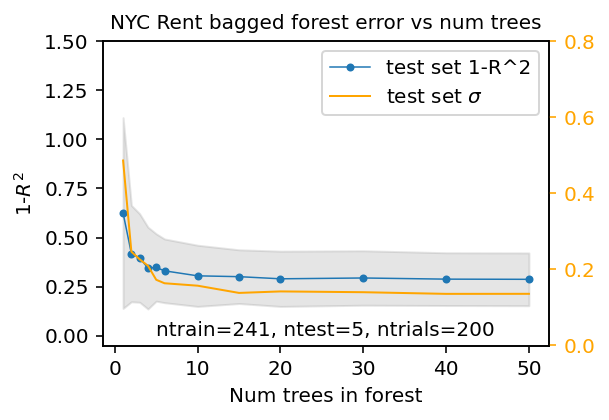

In [11]:
figsize = (4,2.8)
fig, ax = plt.subplots(1, 1, figsize=figsize)

a = ax.plot(tree_sizes, 1-test_means, lw=.75, marker='.', label="test set 1-R^2")

plt.fill_between(tree_sizes, 
                 1-test_means - test_variances,
                 1-test_means + test_variances,
                 color='gray', alpha=0.2)

ax2 = ax.twinx()
b = ax2.plot(tree_sizes, test_variances, lw=1, label="test set $\sigma$", c='orange')
ax2.yaxis.label.set_color('orange')
#ax2.set_ylabel("Test $\sigma$")
ax2.tick_params(axis='y', colors='orange')
ax2.set_ylim(-0.002,.8)

ax.set_xlabel("Num trees in forest")
ax.set_ylabel("1-$R^2$")
ax.set_ylim(-.05,1.5)
lines = a+b
labels = [l.get_label() for l in lines]
ax.legend(lines,labels,loc='upper right')

ax.text(5,.00,f"ntrain={len(X_train)}, ntest={len(X_test)}, ntrials={nchunks}")

if max_features==1.0:
    ax.set_title("NYC Rent bagged forest error vs num trees", fontsize=10)
else:
    ax.set_title("NYC Rent RF error vs num trees", fontsize=10)

## Synthetic data

In [12]:
def syndata(n = 100, ncols = 50):
    "Eqn 15.8 p599 ESLII Hastie et all"
    df = pd.DataFrame()
    for i in range(ncols):
        df[f'x{i}'] = np.random.normal(size=n)
    X = df.values
    y = np.sum(X,axis=1) / np.sqrt(ncols)# + np.random.normal(size=n)
    return X, y

In [13]:
def simulate(ntrials, max_features, min_samples_leaf=1, bootstrap=True):
#     tree_sizes = [1,2,3,4,5,6,7,8,9,10,20,30]#,40,50]#,200,400]
    tree_sizes = [1,2,5,8,10,15,20,30,40,50,100, 200, 300]
    all_test_errors = np.zeros(shape=(ntrials, len(tree_sizes)))
    all_test_scores = np.zeros(shape=(ntrials, len(tree_sizes)))

    # single test set
    X_test, y_test = syndata(n=100)

    print("Trial: ", end='')
    for i in range(ntrials):
        print(f"{i} ", end='')
        X_train, y_train = syndata(n=100) # new train set each trial

        error_per_tree_size = []
        r2_per_tree_size = []
        for n_estimators in tree_sizes:
            rf = RandomForestRegressor(n_estimators=n_estimators,
                                       min_samples_leaf=min_samples_leaf,
                                       max_features=max_features,
                                       bootstrap=bootstrap,
                                       n_jobs=-1)
            rf.fit(X_train, y_train)
#             y_pred = rf.predict(X_test)
#             e = mean_absolute_error(y_test, y_pred)
#             error_per_tree_size.append(e)
            s = rf.score(X_test, y_test)
            r2_per_tree_size.append(s)

#         all_test_errors[i] = error_per_tree_size
        all_test_scores[i] = r2_per_tree_size
    return all_test_errors, all_test_scores, tree_sizes

In [14]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=10, max_features='auto')

Trial: 0 1 2 3 4 5 6 7 8 9 

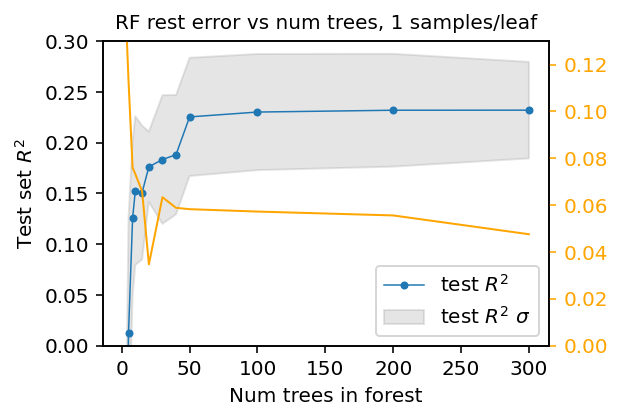

In [15]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features='auto')

In [16]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=20, max_features=1.0)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

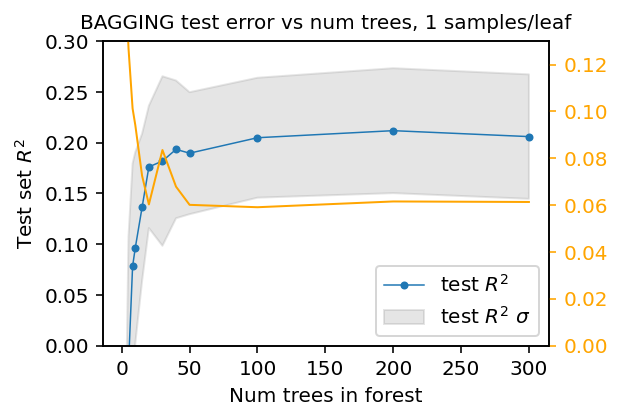

In [17]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1.0)

In [18]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=20, max_features=1)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 

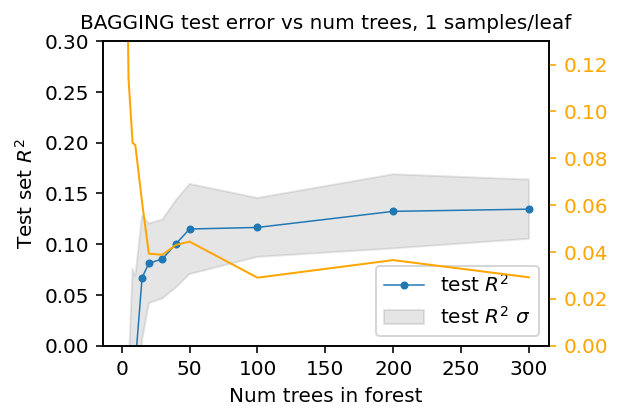

In [19]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1)

In [20]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=100, max_features='auto')

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

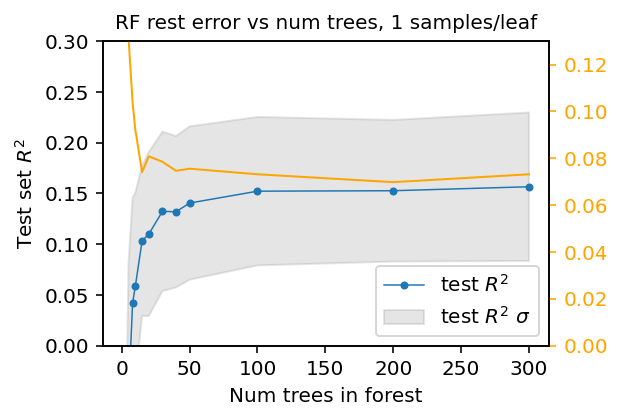

In [21]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features='auto')

In [22]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=100, max_features=1.0)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

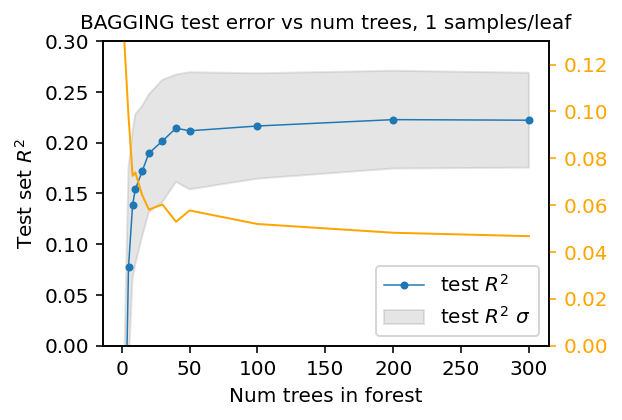

In [23]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1.0)

In [24]:
all_test_errors, all_test_scores, tree_sizes = simulate(ntrials=100, max_features=1)

Trial: 0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96 97 98 99 

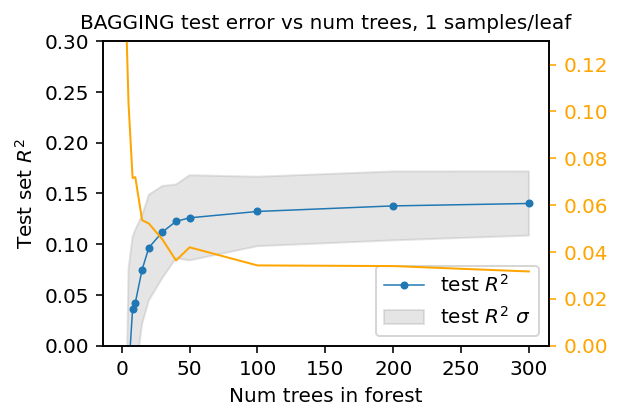

In [25]:
showme(tree_sizes, all_test_errors, all_test_scores, max_features=1)